In [1]:
# 下载数据的函数

import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

def download(name, cache_dir=os.path.join('..', 'data')):
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname # 命中缓存
    print(f"正在从{url}下载{fname}...")
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname



def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [2]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

# data

DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [3]:
# 获得feature部分，做数据预处理
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
all_features.shape

(2919, 79)

In [4]:
## coding
all_features.index # row index
all_features.columns # column name
all_features.values # Return a Numpy representation of the DataFrame
all_features['MSZoning'].values

array(['RL', 'RL', 'RL', ..., 'RL', 'RL', 'RL'], dtype=object)

In [5]:
# 1）处理数值型：0均值 单位方差
numeric_columns = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_columns] = all_features[numeric_columns].apply(
    lambda x : (x - x.mean()) / (x.std()))

# 2）fillna
all_features[numeric_columns] = all_features[numeric_columns].fillna(0)

# 3）处理离散值
all_features = pd.get_dummies(all_features, dummy_na=True) # 只会对非数值项进行独热编码
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征

all_features.shape

(2919, 331)

In [6]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [8]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

hidden1, hidden2 = 256, 64

def get_net():
    net = nn.Sequential(nn.Linear(in_features, hidden1), nn.ReLU(),
                       nn.Linear(hidden1, hidden2), nn.ReLU(),
                       nn.Linear(hidden2, 1))
    return net

# 测试，以评估误差
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                          torch.log(labels)))
    return rmse.item()

In [9]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 使用Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [10]:
# K折交叉验证

# 取出第i份数据
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j+1)*fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.745669, 验证log rmse1.293767
折2，训练log rmse0.589343, 验证log rmse0.707048
折3，训练log rmse1.491911, 验证log rmse1.255470
折4，训练log rmse1.896162, 验证log rmse1.896875
折5，训练log rmse0.346932, 验证log rmse0.181576
5-折验证: 平均训练log rmse: 1.014003, 平均验证log rmse: 1.066947


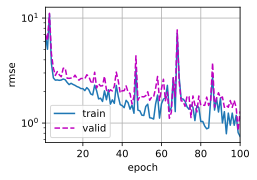

In [13]:
# 模型选择。调参&改进模型

k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

折1，训练log rmse0.128986, 验证log rmse0.218058
折2，训练log rmse0.118145, 验证log rmse0.194669
折3，训练log rmse0.120900, 验证log rmse0.176497
折4，训练log rmse0.123915, 验证log rmse0.176026
折5，训练log rmse0.111288, 验证log rmse0.167766
5-折验证: 平均训练log rmse: 0.120647, 平均验证log rmse: 0.186603


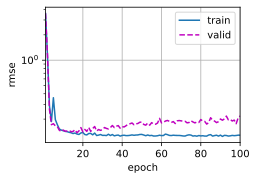

In [16]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.01, 10, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

折1，训练log rmse0.133742, 验证log rmse0.154628
折2，训练log rmse0.129596, 验证log rmse0.148939
折3，训练log rmse0.128699, 验证log rmse0.145795
折4，训练log rmse0.137204, 验证log rmse0.139863
折5，训练log rmse0.127880, 验证log rmse0.169398
5-折验证: 平均训练log rmse: 0.131424, 平均验证log rmse: 0.151724


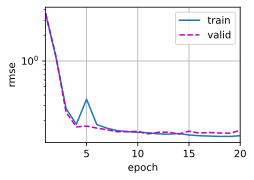

In [19]:
k, num_epochs, lr, weight_decay, batch_size = 5, 20, 0.01, 50, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

折1，训练log rmse0.143506, 验证log rmse0.144898
折2，训练log rmse0.141873, 验证log rmse0.156583
折3，训练log rmse0.136887, 验证log rmse0.143837
折4，训练log rmse0.143413, 验证log rmse0.141715
折5，训练log rmse0.138666, 验证log rmse0.172839
5-折验证: 平均训练log rmse: 0.140869, 平均验证log rmse: 0.151974


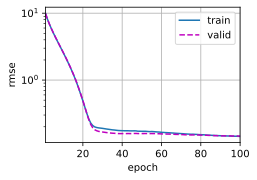

In [11]:
'''
net = nn.Sequential(nn.Linear(in_features, hidden1), nn.ReLU(),
                       nn.Linear(hidden1, hidden2), nn.ReLU(),
                       nn.Linear(hidden2, 1))
调参最优 valid=0.150
'''
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.001, 100, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

折1，训练log rmse0.130645, 验证log rmse0.144093
折2，训练log rmse0.128440, 验证log rmse0.147388
折3，训练log rmse0.126944, 验证log rmse0.142951
折4，训练log rmse0.132608, 验证log rmse0.136192
折5，训练log rmse0.125405, 验证log rmse0.167372
5-折验证: 平均训练log rmse: 0.128808, 平均验证log rmse: 0.147599


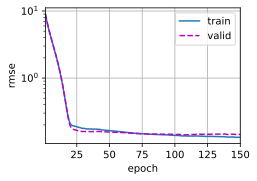

In [10]:
k, num_epochs, lr, weight_decay, batch_size = 5, 150, 0.001, 100, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

训练log rmse：0.127829
float32 (1459, 1)


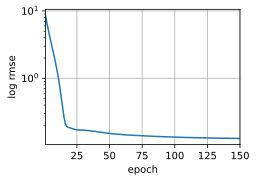

In [23]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    print(preds.dtype, preds.shape)
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)
    
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)